## Eyes Classification

Dataset Link: https://www.kaggle.com/datasets/pavelbiz/eyes-rtte

Task: Implement a classifier using a Neural network using Keras Framework to determine gender by eye.

I'll be implementing 3 classification models:
1. Benchmark Model with SVM
2. Multilayer Perceptron Model
3. Convolution Neural Networks

In [1]:
#importing libraries
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import torch
from skimage.transform import resize
from skimage.io import imread

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import TensorBoard
#num_classes = 10
#epochs = 20

%matplotlib inline

### Importing Dataset

In [2]:
from os.path import split
import glob
path = '/content/drive/MyDrive/College/AIDI 1009/dataset'
path_img = list(glob.glob(path+'/**/*.jpg'))

labels = list(map(lambda x:split(split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)

labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/drive/MyDrive/College/AIDI 1009/datas...,maleeyes
1,/content/drive/MyDrive/College/AIDI 1009/datas...,femaleeyes
2,/content/drive/MyDrive/College/AIDI 1009/datas...,femaleeyes
3,/content/drive/MyDrive/College/AIDI 1009/datas...,maleeyes
4,/content/drive/MyDrive/College/AIDI 1009/datas...,femaleeyes


### Exploratory Data Analysis

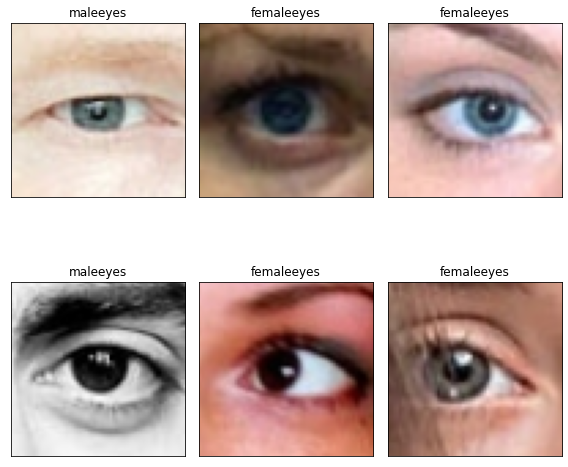

In [3]:
image_resize_shape = (64, 64, 3)
x = np.array([resize(imread(file_path), image_resize_shape, anti_aliasing=True) 
                for file_path in data.File_Path])
y = np.array([1 if label == "femaleeyes" else 0 for label in data.Labels])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i])
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

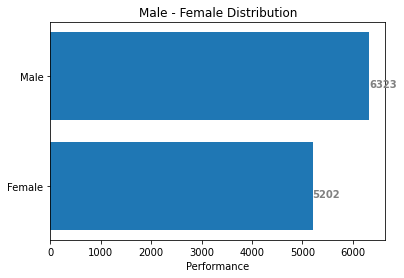

11525
Male, Female Probs = 0.549, 0.451


In [ ]:
counts = data.Labels.value_counts()
fig, ax = plt.subplots()
hbars = ax.barh([0, 1], counts, align='center')
ax.set_yticks([0, 1])
ax.set_yticklabels(("Male", "Female"))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Male - Female Distribution')

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.show()
print(sum(counts))
print("Male, Female Probs = {:.3}, {:.3}".format(counts[0]/sum(counts), counts[1]/sum(counts)))

The dataset has more male eyes image samples than the female eyes image samples, but the difference is not so much, so the dataset is balanced

In [4]:
n_samples = x.shape[0]  # The total number of samples in the dataset

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## Generating a shuffled vector of indices
indices = np.arange(n_samples)
rand_gen.shuffle(indices)

## Split the indices into 60% train / 20% test
train_indices = indices[:int(0.8 * n_samples)]
test_indices = indices[int((0.8) * n_samples):]


## Extract the sub datasets from the full dataset using the calculated indices
X_train = x[train_indices]
y_train = y[train_indices]
X_test = x[test_indices]
y_test = y[test_indices]

### Model 1: Benchmark Model (SVM Model from Sklearn)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(9220, 64, 64, 3)
(2305, 64, 64, 3)


In [5]:
x_train = X_train.reshape(9220,3*64*64)
x_test = X_test.reshape(2305,3*64*64)

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='linear',gamma='auto')
svc.fit(x_train, y_train)

SVC(gamma='auto', kernel='linear')

In [ ]:
y_pred = svc.predict(x_test)

In [ ]:
from sklearn import metrics
print("Classification report for - \n{}:\n{}\n".format(
    svc, metrics.classification_report(y_test, y_pred)))
print("Accuracy Score is: ", metrics.accuracy_score(y_test, y_pred))

Classification report for - 
SVC(gamma='auto', kernel='linear'):
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1247
           1       0.81      0.81      0.81      1058

    accuracy                           0.83      2305
   macro avg       0.82      0.82      0.82      2305
weighted avg       0.83      0.83      0.83      2305


Accuracy Score is:  0.8260303687635575


For SVM Model, I had to reshape the dataset from its original shape because SVM model can only train with two dimensions. The SVM Model did a good job in prediction as we can see in the classification report above, although we had better precision, recall and f1-score for the 0 label which is male eyes. We also had an 82% accuracy score on the test dataset.

### Model 2: Multilayer Perceptron Model

In [6]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

In [7]:
# Change the labels from integer to categorical data
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [ ]:
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)

(9220, 2)
(2305, 2)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping

early_stop=EarlyStopping(patience=4)

classes_num = 2

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(12288,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(classes_num, activation='softmax'))

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(x_train, y_train_one_hot, batch_size=128, epochs=50, verbose=1,
                   validation_data=(x_test, y_test_one_hot), callbacks=[early_stop])

Epoch 1/50
73/73 [==============================] - 1s 14ms/step - loss: 1.1037 - accuracy: 0.5954 - val_loss: 0.7208 - val_accuracy: 0.5800
Epoch 2/50
73/73 [==============================] - 1s 9ms/step - loss: 0.5394 - accuracy: 0.7290 - val_loss: 0.5832 - val_accuracy: 0.6911
Epoch 3/50
73/73 [==============================] - 1s 10ms/step - loss: 0.4811 - accuracy: 0.7704 - val_loss: 0.4372 - val_accuracy: 0.8108
Epoch 4/50
73/73 [==============================] - 1s 9ms/step - loss: 0.4378 - accuracy: 0.7972 - val_loss: 1.2232 - val_accuracy: 0.5861
Epoch 5/50
73/73 [==============================] - 1s 10ms/step - loss: 0.4723 - accuracy: 0.7792 - val_loss: 0.4209 - val_accuracy: 0.8039
Epoch 6/50
73/73 [==============================] - 1s 10ms/step - loss: 0.3957 - accuracy: 0.8193 - val_loss: 0.6230 - val_accuracy: 0.6846
Epoch 7/50
73/73 [==============================] - 1s 9ms/step - loss: 0.4194 - accuracy: 0.8029 - val_loss: 0.4079 - val_accuracy: 0.8065
Epoch 8/50
73/73

In [20]:
[test_loss, test_acc] = model.evaluate(x_test, y_test_one_hot)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

73/73 [==============================] - 0s 3ms/step - loss: 0.3449 - accuracy: 0.8516
Evaluation result on Test Data : Loss = 0.34486642479896545, accuracy = 0.8516268730163574


Text(0.5, 1.0, 'Accuracy Curves')

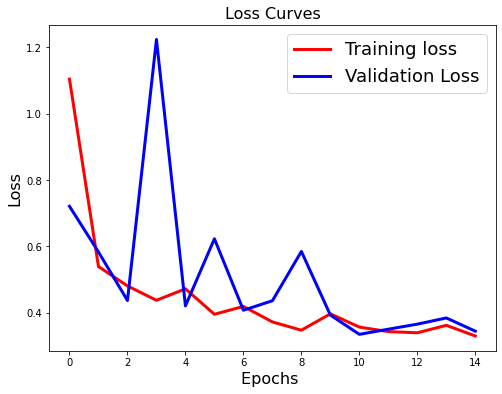

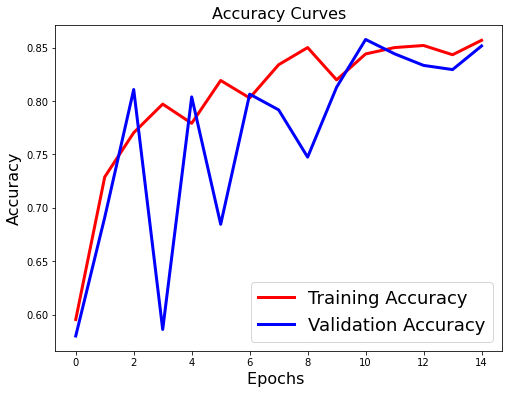

In [21]:
#Plot the Loss Curves

plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

 

#Plot the Accuracy Curves

plt.figure(figsize=[8,6]) 
plt.plot(history.history['accuracy'],'r',linewidth=3.0) 
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0) 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16), plt.ylabel('Accuracy',fontsize=16) 
plt.title('Accuracy Curves',fontsize=16)

In [22]:
from sklearn.metrics import classification_report
# evaluate the network
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test_one_hot.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1284
           1       0.91      0.74      0.82      1021

    accuracy                           0.85      2305
   macro avg       0.86      0.84      0.85      2305
weighted avg       0.86      0.85      0.85      2305



For the MLP Model, I used OneHotEncoding for the labels. I also used earlystopping because the model was overfitting during the first run. Looking at the scores, the 0 label which is the male eyes had significantly better recall and f1-score than 1 label, while the 1 label had a better precision score. Overall the MLP model is doing well in prediction, with accuracy of 85% on the test dataset.

### Model 3: CNN

In [5]:
import keras
from keras.layers import BatchNormalization,Conv2D,MaxPool2D,Dense,Flatten,Input,GlobalMaxPooling2D,Dropout
! pip install visualkeras
import visualkeras
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
model=Sequential()
model.add(Input(shape=(64,64,3)))
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
# model.add(keras.layers.Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

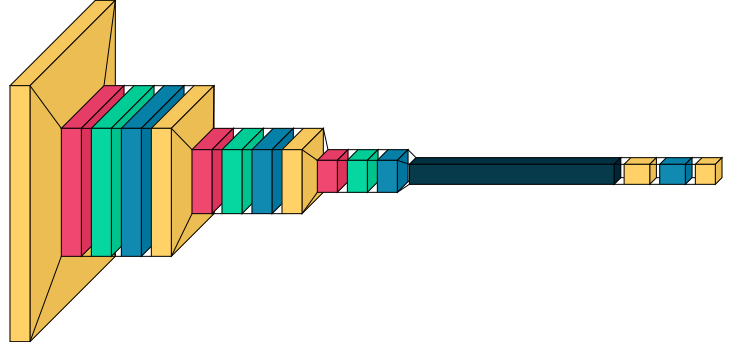

In [25]:
visualkeras.layered_view(model)

In [7]:
early_stop=EarlyStopping(patience=4)
reduce_lr=ReduceLROnPlateau(patience=2)

In [11]:
cnn_hist=model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                   epochs=20, callbacks=[early_stop,reduce_lr])

Epoch 1/20
289/289 [==============================] - 7s 23ms/step - loss: 0.0672 - accuracy: 0.9756 - val_loss: 0.1553 - val_accuracy: 0.9514 - lr: 0.0010
Epoch 2/20
289/289 [==============================] - 5s 18ms/step - loss: 0.0538 - accuracy: 0.9799 - val_loss: 0.1978 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 3/20
289/289 [==============================] - 5s 16ms/step - loss: 0.0465 - accuracy: 0.9831 - val_loss: 0.2443 - val_accuracy: 0.9328 - lr: 0.0010
Epoch 4/20
289/289 [==============================] - 4s 15ms/step - loss: 0.0347 - accuracy: 0.9879 - val_loss: 0.1474 - val_accuracy: 0.9531 - lr: 1.0000e-04
Epoch 5/20
289/289 [==============================] - 4s 15ms/step - loss: 0.0243 - accuracy: 0.9920 - val_loss: 0.1439 - val_accuracy: 0.9584 - lr: 1.0000e-04
Epoch 6/20
289/289 [==============================] - 4s 14ms/step - loss: 0.0225 - accuracy: 0.9931 - val_loss: 0.1453 - val_accuracy: 0.9570 - lr: 1.0000e-04
Epoch 7/20
289/289 [==============================] 

In [24]:
[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

73/73 [==============================] - 1s 7ms/step - loss: 0.1484 - accuracy: 0.9597
Evaluation result on Test Data : Loss = 0.14835914969444275, accuracy = 0.9596529006958008


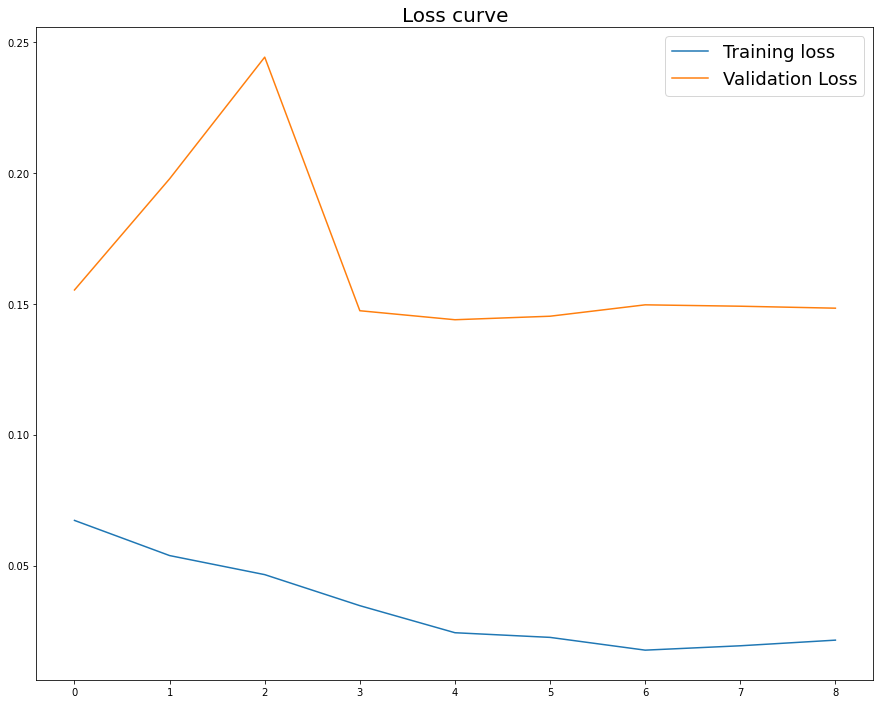

In [12]:
plt.figure(figsize=(15,12))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.title('Loss curve',fontdict={'size':20})
plt.show()

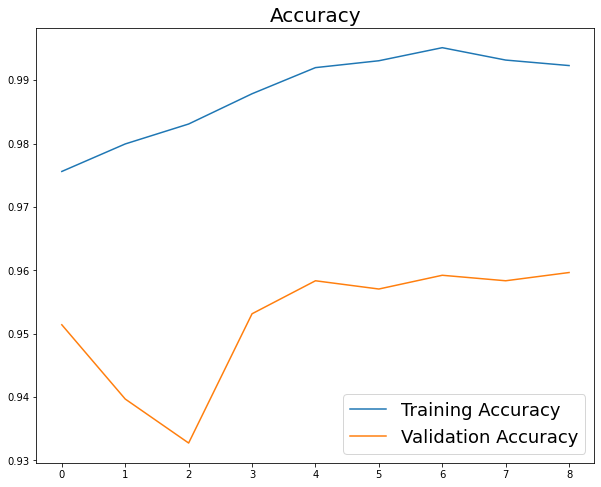

In [14]:
plt.figure(figsize=(10,8))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.title('Accuracy',fontdict={'size':20})
plt.show()

In [23]:
classes_x = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test,classes_x))



              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1259
           1       0.96      0.95      0.96      1046

    accuracy                           0.96      2305
   macro avg       0.96      0.96      0.96      2305
weighted avg       0.96      0.96      0.96      2305



For the third model, which is the CNN model. Our model performed greatly in prediction with over 95% precision, recall and f1-score for both classes. I also used earlystopping with patience of 4 to stop the training when the loss stops reducing and ReduceLROnPlateau for reducing learning rate when our scores have stopped improving with a patience of 2, this was added to prevent our model from overfitting. I also used batchnormalization to speed up training and make learning easier for our Convolutional Neural Network and dropouts in the architecture, so as to also prevent overfitting.

### Conclusion

#### Comparing the three Models

| Model |Accuracy Score on Test Dataset |
| --- | --- |
| SVM | 0.826 |
| MLP | 0.851 |
| CNN | 0.959 |

So we observe that the CNN Model performed best in our image classification dataset. it performed significantly better than the other two models. The MLP and SVM models also had good accuracy scores, but the CNN model performed the best amongst the 3 models.